# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json
import sys

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [3]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

[1591 5608]
[0 1 2]


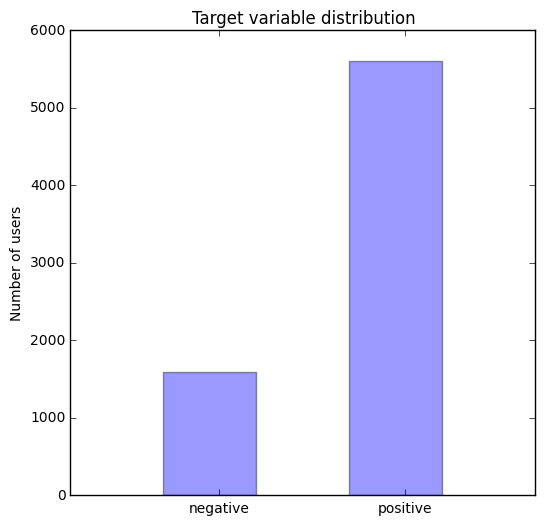

In [4]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])
print(counts)
print(bins)
# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [5]:
CONSUMER_KEY = "UjCifMvqGbRgDiZ6q9kTRiiaK"
CONSUMER_SECRET = "o8n9mSRxY1VPeo5w0Hp5Z9CSrZ7rcrcSTXohs9xacNPM26LQHL"

ACCESS_TOKEN_KEY = "3028262626-xhiyNFEy7QtzPtiqklqSAhZUihuFIph1lzXutuQ"
ACCESS_TOKEN_SECRET = "ZxKxjshSNrXnU0k05Ta5v81apcYd4TbZLDAqzSqsxHJXe"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [6]:
GEO_USER_NAME = "abadaba1"
GEO_CACHE_FILENAME = '.location_cache'
locationFileCache = None
locationMemCache = {}
def get_coordinates_by_location(location):
    
    escaped_symbols = [u'#', u'&', u'^', u'|', u'-', u'?', '"']
    for symbol in escaped_symbols:
        if location.find(symbol) != -1:
            location = location.replace(symbol, '')
    
    
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    
    NOTE: the returned value is FAKE. It's only used to show
    NOTE: correct output format.
    """
    
    global locationFileCache
    
    if len(locationMemCache.items()) == 0: ## load LocationCache
        if  os.path.exists(GEO_CACHE_FILENAME):
            print("Loading location cache")
            with open(GEO_CACHE_FILENAME) as flCache:
                for line in flCache:
                    try:
                        data = json.loads(line)
                        locationMemCache[data['key']] = data['data']
                    except:
                        continue
    
    
    if locationFileCache is None:
        locationFileCache = open(GEO_CACHE_FILENAME, 'a')
        
    
    try:
        if location in locationMemCache.keys():
            print(u"Location {0} Loading response from cache".format(location))
            response = locationMemCache[location]
        else:
            print('Requesting Location')
            print(location)
            r = requests.get(u'http://api.geonames.org/searchJSON?q="{0}"&username={1}'.format(location, GEO_USER_NAME))
            responses = r.json()['geonames']
            response = {'lat':'0.0', 'lng':'0.0','countryName':'InvalidCountryName'}
            if len(responses) == 0:
                print(u"Location {0} Response = {1}".format(location, r.json()))
            else:
                response = responses[0]
            for response in responses:
                    if 'countryName' in response.keys() and len(response['countryName']) > 0 and 'lat' in response.keys() and 'lng' in response.keys():
                        saveEntry = {}
                        saveEntry['key'] = location
                        saveEntry['data'] = response
                        try:
                            locationFileCache.write(json.dumps(saveEntry) + '\n')
                        except:
                            pass
                        locationMemCache[location] = response
                        break
        print(u"GeoResponse lat=={0}, long == {1}, country={2}".format(response['lat'], response['lng'], response['countryName']))
        return (float(response['lat']), float(response['lng']), response['countryName'])
    except e:
        print(r.json())
        print(e)
        raise e
    # your code here
    return (55.75222, 37.61556, u'Russia')

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [ ]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    print("Loading cache")
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except Exception as e:
                print(e)
                continue
    print("Loading cache complete {0} items".format(len(user_records)))

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


def get_user_from_api(buff):
    return api.GetUser(buff)

def get_user_records(df, processed_users, mem_cache):
    global locationFileCache
    # your code here
    # some_downloaded_user = get_user_from_api
    # also write user as json line in temporary file
    # return [twitter_user_to_dataframe_record(some_downloaded_user)]
    from time import sleep
    it = 0
    users = []
    print("Cache length {0} ".format(len(user_records)))
    for val in df.values:
        uid, clclass = int(val[0]), int(val[1])
        downloaded_user = {}
        if uid in processed_users:
            for r in mem_cache:
                if (r['uid'] == uid):
                    #print("Loading User={0} from cache".format(uid))
                    users.append(r)
                    it += 1
                    break
        else:
            try:
                downloaded_user = get_user_from_api(uid)
            except twitter.error.TwitterError as e:
                print("TwitterError on user{0}".format(uid))
                print(e)
                if (len(e.message) and 'code' in e.message[0].keys() and (int (e.message[0]['code']) == 50 or int(e.message[0]['code']) == 63)):
                    print("Invalid User id skipping")
                    continue
                else:
                    f.flush()
                    if not locationFileCache is None:
                        locationFileCache.flush()
                    sleep(60 * 15)
                    continue
            except Exception as e:
                print("Exception on user{0}".format(uid))
                print(e)
                f.flush()
                if not locationFileCache is None:
                    locationFileCache.flush()
                sleep(60 * 15)
                continue
            except:
                print("Exception on user{0}".format(uid))
                print "Unexpected error:", sys.exc_info()[0]
                f.flush()
                if not locationFileCache is None:
                    locationFileCache.flush()
                sleep(60 * 15)
                continue

            processed_user = twitter_user_to_dataframe_record(downloaded_user)
            f.write(json.dumps(processed_user) + '\n')

            users.append(processed_user)
            #print("It={0} Processed uid={1}".format(it, uid))
            it += 1
        
    f.flush()
    if not locationFileCache is None:
        locationFileCache.flush()
    return users

# Maximum number of user IDs returned by Twitter's user lookup

user_records = get_user_records(df_users, processed_users, user_records)

        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

Loading cache
Loading cache complete 5145 items
Cache length 5145 
TwitterError on user720288026681716736
TwitterError on user707400118807482368
TwitterError on user719914275771428864
TwitterError on user756335606607720448
TwitterError on user3091562110
TwitterError on user742777527467380736
TwitterError on user768806279309512704
TwitterError on user752347799623196672
TwitterError on user710613745374920704
TwitterError on user760201676187918336
TwitterError on user769649548604084224
TwitterError on user725850449765535744
TwitterError on user752621591209488384
TwitterError on user723516845425184768
TwitterError on user734632509326151680
TwitterError on user741006180093440000
TwitterError on user769588045859459072
TwitterError on user764455186601504768
TwitterError on user1622658864
TwitterError on user768806253841649664
TwitterError on user969130340
TwitterError on user721422997177937920
TwitterError on user730393178512175104
TwitterError on user741069969920819200
TwitterError on user73

## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

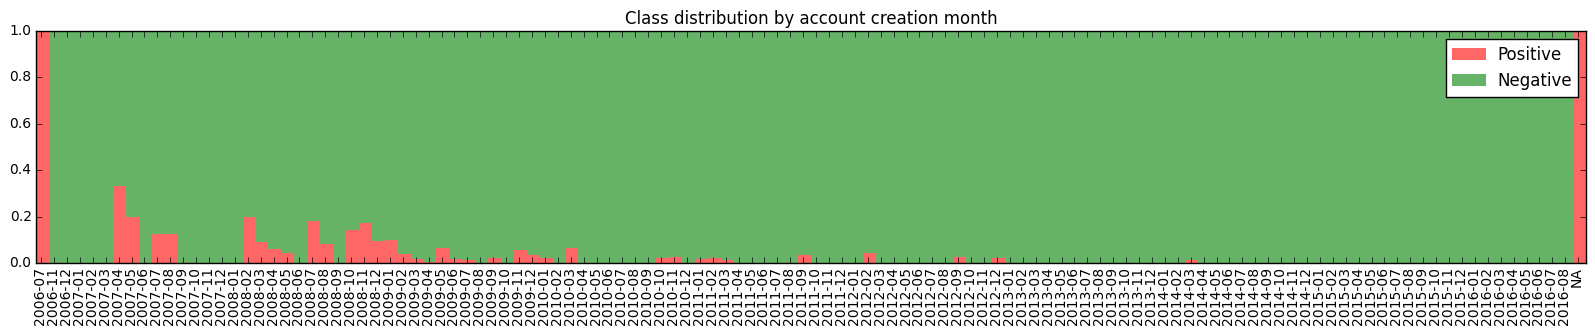

In [19]:
def count_users(grouped):
    #print(grouped.apply.__doc__)
    #print(grouped.apply(n['created_at']
    
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    pos_cnt = []
    neg_cnt = []
    print(grouped)
    
    for year, item in grouped:
        dts.append(year)
        pos_cnt_y, neg_cnt_y = 0, 0
        for it in item['verified']:
            if (it):
                pos_cnt_y += 1
            else:
                neg_cnt_y += 1
        neg_cnt.append(neg_cnt_y)
        pos_cnt.append(pos_cnt_y)
    
    count_pos, count_neg = np.array(pos_cnt), np.array(neg_cnt)
    # your code here 
    
    #count_pos = np.array(count_)
    return count_pos, count_neg, dts

grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

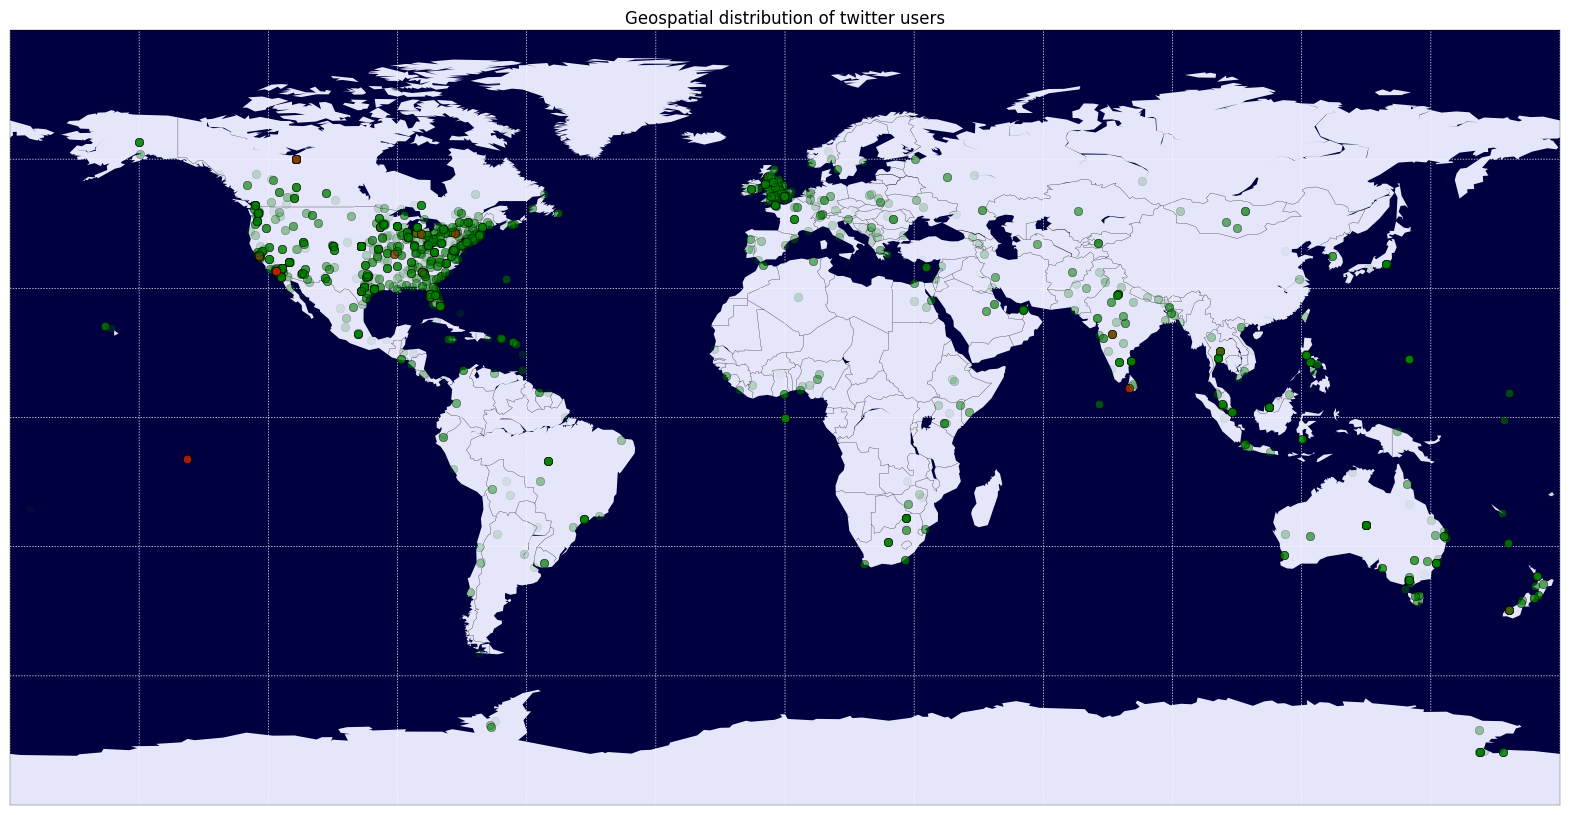

In [18]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

SP_S = 100000
def plot_points_on_map(df_full):
    grp = df_full.groupby(['lat', 'lon'])
    plst = []
    for coords,items in grp:
        lat, lon = coords
        xpt, ypt = m(lon, lat)
        m(xpt,ypt,inverse=True)
        for it in items['verified']:
            if it:
                plst.append((xpt, ypt, True))
            else:
                plst.append((xpt, ypt, False))
                
    from random import shuffle
    shuffle(plst)
    penalty = .0
    lx,ly = 0, 0
    isLastNeg = False
    l = []
    for item in plst:
        xpt,ypt, pos_cnt = item
        m(xpt,ypt,inverse=True)
        if pos_cnt:
            pos_cnt = 1.
            neg_cnt = .0
        else:
            pos_cnt = 0.
            neg_cnt = 1.
        if (isLastNeg and neg_cnt) or (not isLastNeg and 0. == neg_cnt):
            penalty += 0.005
            l.append((xpt, ypt))
        else:
            gc = 'go'
            rc = 'ro'
            for i in l:
                xpt, ypt = i
                if ((xpt - lx)*(xpt - lx) + (ypt - ly)*(ypt - ly)) > SP_S:
                    #print((xpt - lx)*(xpt - lx) + (ypt - ly)*(ypt - ly))
                    penalty = 0
                pcoeff = 0.3 + penalty *(SP_S - ((xpt - lx)*(xpt - lx) + (ypt - ly)*(ypt - ly))) / SP_S
                coeff = 1. - pcoeff
                if (coeff < .0):
                    coeff = min(0.8, -coeff)

                if pos_cnt > neg_cnt:
                    m.plot(xpt, ypt, gc, alpha=coeff)
                    if neg_cnt:
                        m.plot(xpt, ypt, rc, alpha = 1. - coeff)
                else:
                    if pos_cnt:
                        m.plot(xpt, ypt, gc, alpha = 1.- coeff)
                    if neg_cnt:
                        m.plot(xpt, ypt, rc, alpha = coeff)
            l = []
            l.append((xpt,ypt))
                    
            
            penalty = 0.0
        
                
        isLastNeg = neg_cnt == 1.
        lx,ly = xpt,ypt
        
    """
    Plot points on the map. Be creative.
    """
    # your code here
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Использование alpha канала для выделения отдельных пиков посреди большинства точек другого цвета
* Случайный порядок рисования точек

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения? Потому что теорвер, это разные величины что mean == median.
        2. Пользователи какого класса популярнее? Негативного, т.к старе пользователи
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

Neg mean= 4647.43103448	Pos mean=4024.58583106
Neg med= 352.0	Pos med=388.0


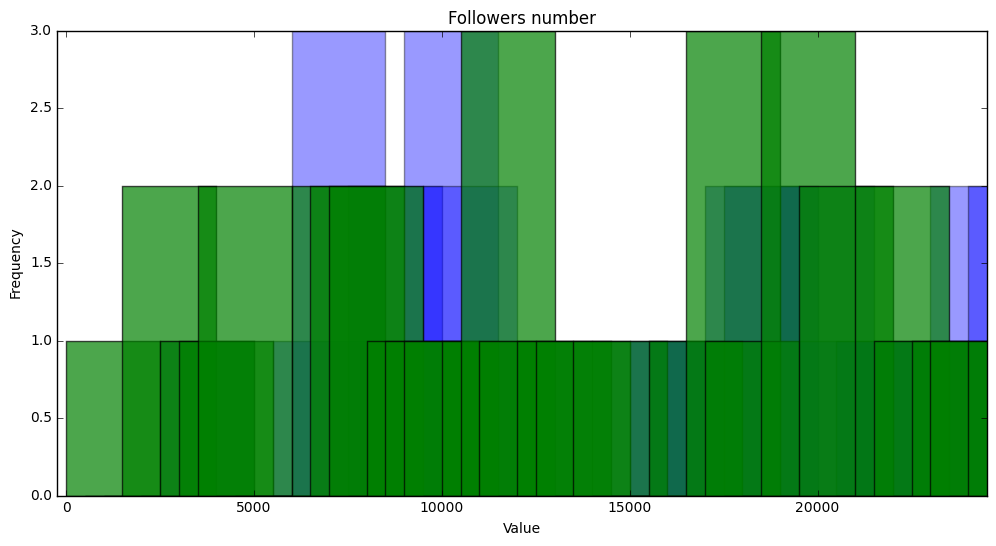

In [65]:
sample_number = 500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)

def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
    pmean = np.nanmean(users_wth_neg_class['followers_count'])
    nmean = np.nanmean(users_wth_pos_class['followers_count'])
    print("Neg mean= {0}\tPos mean={1}".format(nmean, pmean))
    
    pmedian = np.nanmedian(users_wth_neg_class['followers_count'])
    nmedian = np.nanmedian(users_wth_pos_class['followers_count'])
    
    print("Neg med= {0}\tPos med={1}".format(nmedian, pmedian))
    
    p_pos = users_wth_pos_class['followers_count']
    p_neg = users_wth_neg_class['followers_count']
    
    neg,bins = np.histogram(p_pos, bins=[x for x in xrange(sample_number / 10)], range=(p_neg.min(), p_neg.max()))
    pos,bins = np.histogram(p_neg, bins=[x for x in xrange(sample_number / 10)], range=(p_pos.min(), p_pos.max()))
# Plot the distribution
    pl.figure(figsize=(12,6))
    h_pos = pl.bar(bins[:-1], pos, width=5, alpha=0.4, color='b', label='Distribution of followers count by positive class users')
    h_neg = pl.bar(bins[:-1], neg, width=5, alpha=0.7, color='g', label='Distribution of followers count by negative class users')
        
    pl.xticks([x for x in xrange(0,sample_number,10)], [str(x) for x in xrange(0,25000,5000)])
    pl.xlim(bins[0] - 0.5, bins[-1])
    pl.xlabel("Value")
    pl.ylabel("Frequency")
    pl.title("Followers number")
    #plt.legend(bbox_to_anchor=(1.5, 0.8), bbox_transform=plt.gcf().transFigure, handles=[h_pos, h_neg])

    pl.show()
        #Calculate min max and median. Plot histogram
        #Your code here
    return
descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class)


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [65]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,39.76,-98.5,United States,2009-05,7623,4285,50630,787,417
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,15.20825,145.75313,Northern Mariana Islands,2009-04,1909,1240,7130,128,96
2,3314758074,0,Campaign Trump,Campaign_Trump,Moving on to Super Tuesday. Indp. Local & Inte...,False,"Houston, TX",29.76328,-95.36327,United States,2015-08,16396,12156,695,6824,146
3,14311688,0,Bernard Whitman,BernardWhitman,"Democratic strategist, pollster, and corporate...",False,New York,40.71427,-74.00597,United States,2008-04,1754,1292,7325,157,112
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,None,None,None,2010-02,1466,1187,37043,3303,78
